2단계) 데이터 요약(요약통계, 상관계수), 결손치, 이산화작업

In [1]:
import pandas as pd
df = pd.read_csv('sample02.csv', index_col='name')  # 샘플링

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as datasets

In [11]:
from sklearn import datasets

data = datasets.load_iris()
print('data shape :', data.data.shape)
print('feature_names :', data.feature_names) 
print('target :', data.target)  # 범주형 변수
print('class name :', data.target_names)

data shape : (150, 4)
feature_names : ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
target : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
class name : ['setosa' 'versicolor' 'virginica']


In [10]:
# 1. 데이터 요약
iris_data = datasets.load_iris()

iris = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
iris['species'] = lris_data.target
iris.head()

# 범주형 변수는 통계량 표시에서 제외가 된다.  DataFrame.describe
iris.iloc[:,:4].describe()

# 범주형 데이터인 species의 빈도수를 확인해보자  Series.value_counts()
iris['species'].value_counts()

2    50
1    50
0    50
Name: species, dtype: int64

array([[<AxesSubplot:title={'center':'sepal length (cm)'}>,
        <AxesSubplot:title={'center':'sepal width (cm)'}>,
        <AxesSubplot:title={'center':'petal length (cm)'}>,
        <AxesSubplot:title={'center':'petal width (cm)'}>,
        <AxesSubplot:title={'center':'species'}>]], dtype=object)

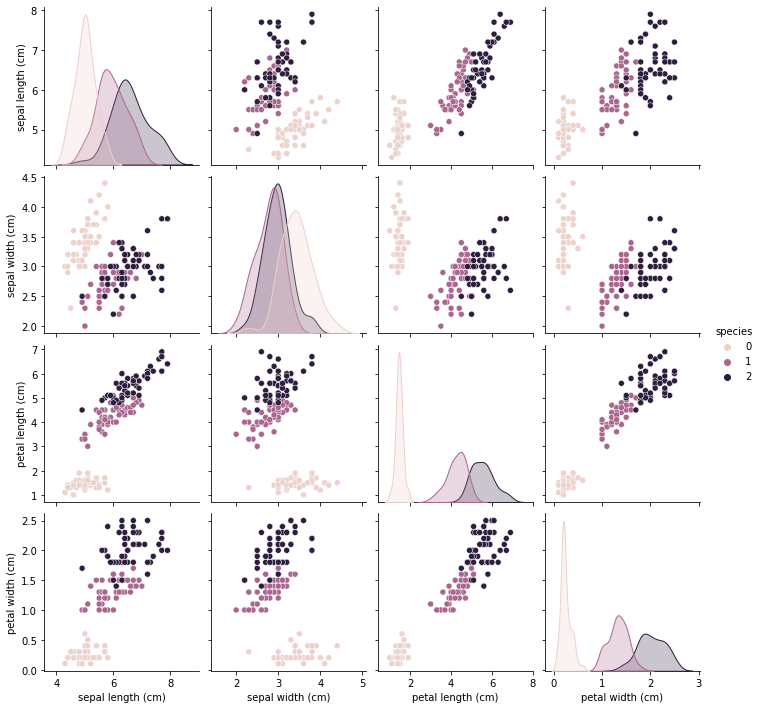

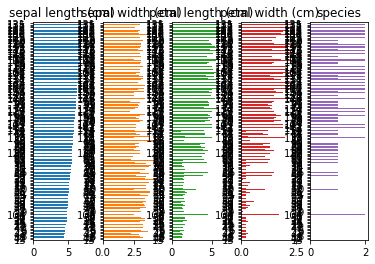

In [16]:
# 1. 데이터 요약 _상관계수, 분산형 행렬
# 상관계수를 호출해보자 DataFrame.corr()
iris.iloc[:,:4].corr()

# 산점도 행렬 seaborn.pairplot
sns.pairplot(iris, hue='species')

# R{tabplot} = data.frame
iris.sort_values('sepal length (cm)').plot.barh(subplots=True, layout=(1,5), sharex=False, legend=False)

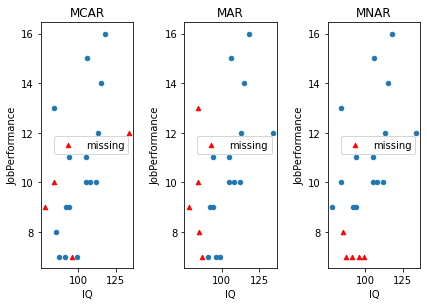

In [21]:
# 2. 결손치
# emp_IQ.csv : IQ에 따른 업무성과(Job Performance)의 관련된 파일
# MCR : 무작위 데이터
# MAR : IQ가 낮을 경우 업무성과(Job Performance)의 적자가 많다(다른 변수값과 관련된 결손 데이터)
# MNAR : 업무성과(Job Performance)에 대한 애착도, 진정성이 낮을 경우 적자가 많다(현재 컬럼 현재 데이터 자신과의 결손데이터)

# 데이터를 로드하자
df = pd.read_csv('emp_IQ.csv')
df.head()

# 결손 데이터를 시각화 해보자 : 해당 컬럼에 결손값과 아닌값을 분류 해서 시각처리
fig, axes = plt.subplots(1,3)
fig.tight_layout(w_pad=2.0)
for col, ax in zip(['MCAR', 'MAR', 'MNAR'], axes):
    indexer = df[col].isnull()  # 결손 데이터 추출
    df[indexer].plot.scatter(x='IQ', y='JobPerformance', marker='^', color='red', label='missing', ax=ax)
    df[~indexer].plot.scatter(x='IQ', y='JobPerformance', ax=ax)
    ax.set_title(col)

In [45]:
# 데이터의 여러변수에 결손값이 다량으로 생성될 경우 그룹화 구현 후 집계
nes = pd.read_csv('sample03.csv', index_col=0)

# 1. 원본 카피
missing = nes.copy()

# 2. copy 데이터의 결손값을 True로 추출
missing = missing.apply(pd.isnull, axis=0)
missing['count'] = 1

#  3. 데이터의 groupby
res = missing.groupby(['age', 'bmi', 'hyp', 'chi']).sum()
res

count
age bmi   hyp   chi         
1   False False False      1
    True  False False      1
          True  True       1
2   False False False      1
3   True  True  True       1

In [44]:
# # 복사 테이블의 pivot_table 사용
# missing.pivot_table(index='hyp', columns ='bmi', values='count', aggfunc='sum')

bmi,False,True
hyp,,
False,2.0,1.0
True,NaN,2.0


결손데이터를 구현 및 사용 하는 방법
1. 결손 레코드 값을 제거
2. 상관계수 등 2개 이상의 변수를 사용해서 계산을 수행 할 때 해당 변수가 결손되는 경우 제외
3. 결손값을 가지는 변수의 평균값으로 확인(평균대입법)
4. (머신러닝) 결손을 가지는 변수의 값을 회귀식으로 구현해서 확인 : sklearn.linear_model.LinearRegression
    - 결손이 발생하는 변수와 발생에 영향을 주는 변수로 회귀 식을 만들고 만들어진 회귀 식으로 이용하여 결손을 보완한다.

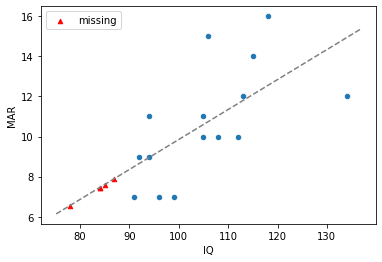

In [77]:
# 결손값 제거 - 회귀식으로 구현  MAR 열을 사용
# 선형회귀 모델 LinearRegression() -> fit(X,y) -> y = predict(X) 
import sklearn.linear_model as lm

df = pd.read_csv('emp_IQ.csv')

reg = lm.LinearRegression()   # 선형회귀 함수
indexer = df['MAR'].isnull()  # MAR 컬럼의 IsNull()로 True/False로 컬럼 생성
reg.fit(df.loc[~indexer, ['IQ']], df.loc[~indexer, 'MAR'])  # null이 아닌 데이터로 fit(X,y) 두가지 변수값 전달. X 기울기, y 절편

predicted = reg.predict(df.loc[indexer, ['IQ']])  # 새로운 X값을 입력해서 y값을 예측
df.loc[indexer, 'MAR'] = predicted  # 예측값을 입력

# 결과
ax = df[indexer].plot.scatter(x='IQ', y='MAR', marker='^', color='red', label='missing')
ax = df[~indexer].plot.scatter(x='IQ', y='MAR', ax=ax)
x = np.linspace(*ax.get_xlim())
ax.plot(x, reg.coef_[0] * x + reg.intercept_, color='gray', linestyle='dashed')
plt.show()

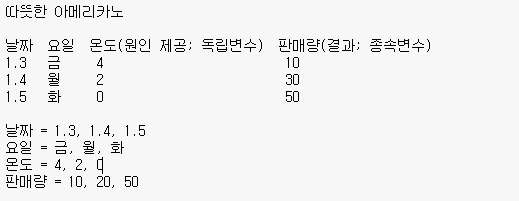


* 온도와 판매량은 상관 관계가 있다.

* 특징
1. 온도와 판매량은 상관 관계가 있다. 온도가 내려갈 때마다 판매량이 증가한다. = 같이 변화한다.
2. 온도와 판매량의 사이에는 다른 경우가 적용되지 않는다 = 영향을 받지 않는다.
3. 판매량이 달라져도 온도는 달라지지 않는다 = 이상
4. 온도가 달라지면 판매량이 달라진다. = 가능하다(맞다 x)
5. 온도가 3도가 되면 몇 잔이 판매될까? 20잔 정도가 팔릴 것이다. = 패턴이 나오고 공식을 확인할 수 있다.

=========================================================================================================

* 인과관계 : 독립변수와 종속변수의 관계(원인과 결과) = 회귀분석

* 상관관계 : 인과관계를 포함. = (단순한 상관 관계) 상관분석

* 회귀분석 : 인과관계에 초점을 두고 분석

* 상관분석 : 단순한 상관관계에 초점을 두고 분석

* 단순 회귀 분석 = 상관분석
  - 두 구간(변수)간의 관계를 분석하기 위한 기법
  - 회귀분석 : 선형관계, 최소 자승법(least squares)을 통해 절편(intercept)과 기울기(slope) 추정
  - 추정치의 표준 오차 : 선형관계의 충분한 증거를 확인 하기 위해 기울기에 대한 검증이 이루어지는 것
  - 결정계수(coefficient of determination) : 선형 관계의 강도
  - 피어슨 상관계수 : 정규 분포를 따르는 두 변수간의 관계를 측정하거나 검증
  
=========================================================================================================

* LinearRegression : 서로 다른 변수들간의 선형 관계를 나타내기 위한 분석 기법(선형회귀)
  - 특정한 변수들의 값을 보고 다른 변수의 값을 추정하기 위한 활용법
  
* 선형회귀모형 : 설명(독립변수)변숭와 종속변수의 관계를 선형으로 나타낸 경우
  - 단순 선형회귀모형(simple linear regression model) : 설명 변수가 한 개인 선형회귀모형
  - 다중 선형회귀모형(multiple linear regression model) : 설명 변수가 두 개 이상인 선형회귀모형
  - 비선형 회귀모형의 반대개념 
  - 참고 : https://danbi-ncsoft.github.io/study/2018/05/04/study-regression_model_summary.html
  

   S_date S_day  Temperature    sales_rate
0     1.3    FR            4  1.000000e+01
1     1.4    SA            3  2.000000e+01
2     1.5    SU            1  4.000000e+01
3     1.6    MO            2  3.000000e+01
4     1.7    TU            0  5.000000e+01
5     1.8    WE            5  7.105427e-15
6     1.9    TH           10 -5.000000e+01


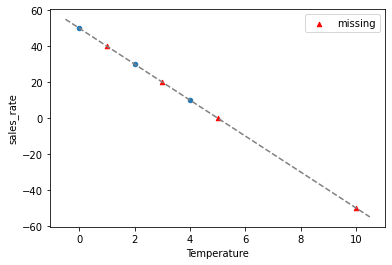

In [84]:
# 결손값 제거 - 회귀식으로 구현  MAR 열을 사용
# 선형회귀 모델 LinearRegression() -> fit(X,y) -> y = predict(X) 
from sklearn.metrics import roc_curve

df = pd.read_csv('data02.csv')

reg = lm.LinearRegression()   # 선형회귀 함수
indexer = df['sales_rate'].isnull()  # sales_rate 컬럼의 IsNull()로 True/False로 컬럼 생성
reg.fit(df.loc[~indexer, ['Temperature']], df.loc[~indexer, 'sales_rate'])  # null이 아닌 데이터로 fit(X,y) 두가지 변수값 전달. X 기울기, y 절편

predicted = reg.predict(df.loc[indexer, ['Temperature']])  # 새로운 X값을 입력해서 y값을 예측(패턴을 보고 자동으로 예측)
df.loc[indexer, 'sales_rate'] = predicted  # null 자리에 예측값을 입력
print(df)

# 결과
ax = df[indexer].plot.scatter(x='Temperature', y='sales_rate', marker='^', color='red', label='missing')
ax = df[~indexer].plot.scatter(x='Temperature', y='sales_rate', ax=ax)
x = np.linspace(*ax.get_xlim())
ax.plot(x, reg.coef_[0] * x + reg.intercept_, color='gray', linestyle='dashed')
plt.show()

In [85]:
import pandas as pd
import numpy as np
from sklearn import linear_model

# 데이터로드
data = pd.read_csv('data.csv', sep=',')

# 선형 회귀 모델
clf = linear_model.LinearRegression()

# 설명 변수 x에 "x1" 데이터를 사용
x = data.loc[:, ['x1']].values

# 목적 변수 y에 'x2' 데이터를 사용
y = data['x2'].values

# 예측 모델을 만들 (단일 회귀)
clf.fit(x,y)

# 매개 변수(회귀 계수, 절편)을 추출
[a] = clf.coef_
b = clf.intercept_

# 매개 변수 표시
print("회귀 계수 :", a)
print('절편 :', b)
print('결정 계수 :', clf.score(x,y))

회귀 계수 : -0.049548095545513246
절편 : 20.11975468043899
결정 계수 : 0.10943356354296774


In [ ]:
3. 이산화 작업 : 데이터 마이닝을 위한 전처리 과정으로서 연속형 변수를 이산형 변수로 바꾸는 과정
  - 목적 : 이산화 시킨 데이터가 원래 가지고 있던 정보 손실을 최소로 하면서 높은 분류정확도를 가지는 것을 목적
  - 4단계 형식
    (1) 연속형 변수의 값을 이산화 하기 위해 정렬한다.
    (2) 합칠 인접한 구간을 정하거나 나누기 위한 분할점(cut-point)을 결정한다.
    (3) 기준(criterion)에 따라 연속형 값의 구간을 합치거나 나눈다.
    (4) 종료기준(stopping criterion)을 만족하면 이산화를 멈춘다.
    
    pandas.cut(대상데이터, bins_범주설정, retbins=True), pandas.qcut()
    pandas.cut(배열값, 분할 수)  : 최대값, 최소값 사이를 분할한다.

In [90]:
# 3-1 이산환 작업
import pandas as pd

s = pd.Series(data = [x**2 for x in range(11)], index=list('abcdefghijk'))
print(s, '\n')

# 등분하자
s_cut = pd.cut(s,4)
print(s_cut)
print(type(s_cut))

a      0
b      1
c      4
d      9
e     16
f     25
g     36
h     49
i     64
j     81
k    100
dtype: int64 

a     (-0.1, 25.0]
b     (-0.1, 25.0]
c     (-0.1, 25.0]
d     (-0.1, 25.0]
e     (-0.1, 25.0]
f     (-0.1, 25.0]
g     (25.0, 50.0]
h     (25.0, 50.0]
i     (50.0, 75.0]
j    (75.0, 100.0]
k    (75.0, 100.0]
dtype: category
Categories (4, interval[float64]): [(-0.1, 25.0] < (25.0, 50.0] < (50.0, 75.0] < (75.0, 100.0]]
<class 'pandas.core.series.Series'>


In [91]:
# 이산화_분할 경계값을 지정
print(pd.cut(s,[0,10,50,100]))  # 경계값을 벗어나면 NaN값 리턴

a              NaN
b      (0.0, 10.0]
c      (0.0, 10.0]
d      (0.0, 10.0]
e     (10.0, 50.0]
f     (10.0, 50.0]
g     (10.0, 50.0]
h     (10.0, 50.0]
i    (50.0, 100.0]
j    (50.0, 100.0]
k    (50.0, 100.0]
dtype: category
Categories (3, interval[int64]): [(0, 10] < (10, 50] < (50, 100]]


In [96]:
# 이산화_분할 경계값을 지정 후 경계값과 목록을 리턴받자
s_cut, bins = pd.cut(s, 4, retbins=True)
print(s_cut, '\n')
print(bins)

a     (-0.1, 25.0]
b     (-0.1, 25.0]
c     (-0.1, 25.0]
d     (-0.1, 25.0]
e     (-0.1, 25.0]
f     (-0.1, 25.0]
g     (25.0, 50.0]
h     (25.0, 50.0]
i     (50.0, 75.0]
j    (75.0, 100.0]
k    (75.0, 100.0]
dtype: category
Categories (4, interval[float64]): [(-0.1, 25.0] < (25.0, 50.0] < (50.0, 75.0] < (75.0, 100.0]] 

[ -0.1  25.   50.   75.  100. ]


In [98]:
# 이산화_분할 경계값을 지정 후 경계값과 목록을 리턴받자
print(pd.cut(s, 4, right=False))  # f의 변화 확인 : 맨 오른쪽에 있는 최대 경계값은 최대값의 0.1% 증가값이 된다.

a      [0.0, 25.0)
b      [0.0, 25.0)
c      [0.0, 25.0)
d      [0.0, 25.0)
e      [0.0, 25.0)
f     [25.0, 50.0)
g     [25.0, 50.0)
h     [25.0, 50.0)
i     [50.0, 75.0)
j    [75.0, 100.1)
k    [75.0, 100.1)
dtype: category
Categories (4, interval[float64]): [[0.0, 25.0) < [25.0, 50.0) < [50.0, 75.0) < [75.0, 100.1)]


In [100]:
# 레이블 지정 labes=None 이 기본, False로 지정하게 되면 정수의 0부터 인덱싱한다.
print(pd.cut(s, 4, labels=False), '\n')
print(pd.cut(s, 4, labels=['small', 'medium', 'large', 'x-large']), '\n')

a    0
b    0
c    0
d    0
e    0
f    0
g    1
h    1
i    2
j    3
k    3
dtype: int64 

a      small
b      small
c      small
d      small
e      small
f      small
g     medium
h     medium
i      large
j    x-large
k    x-large
dtype: category
Categories (4, object): ['small' < 'medium' < 'large' < 'x-large'] 



In [102]:
# 소수이하 자리수
print(pd.cut(s, 3, precision=1))  # precision으로 소수 자리수를 지정

a     (-0.1, 33.3]
b     (-0.1, 33.3]
c     (-0.1, 33.3]
d     (-0.1, 33.3]
e     (-0.1, 33.3]
f     (-0.1, 33.3]
g     (33.3, 66.7]
h     (33.3, 66.7]
i     (33.3, 66.7]
j    (66.7, 100.0]
k    (66.7, 100.0]
dtype: category
Categories (3, interval[float64]): [(-0.1, 33.3] < (33.3, 66.7] < (66.7, 100.0]]


In [104]:
# 이산화 pandas.qcut()
print(pd.cut(s,2), '\n')
print(pd.qcut(s,2))  # 개수별로 균등하게 자동 분할을 해준다

a     (-0.1, 50.0]
b     (-0.1, 50.0]
c     (-0.1, 50.0]
d     (-0.1, 50.0]
e     (-0.1, 50.0]
f     (-0.1, 50.0]
g     (-0.1, 50.0]
h     (-0.1, 50.0]
i    (50.0, 100.0]
j    (50.0, 100.0]
k    (50.0, 100.0]
dtype: category
Categories (2, interval[float64]): [(-0.1, 50.0] < (50.0, 100.0]] 

a    (-0.001, 25.0]
b    (-0.001, 25.0]
c    (-0.001, 25.0]
d    (-0.001, 25.0]
e    (-0.001, 25.0]
f    (-0.001, 25.0]
g     (25.0, 100.0]
h     (25.0, 100.0]
i     (25.0, 100.0]
j     (25.0, 100.0]
k     (25.0, 100.0]
dtype: category
Categories (2, interval[float64]): [(-0.001, 25.0] < (25.0, 100.0]]


In [105]:
print(pd.qcut(s, 4, labels=['Q1', 'Q2', 'Q3', 'Q4'], retbins=True))

(a    Q1
b    Q1
c    Q1
d    Q2
e    Q2
f    Q2
g    Q3
h    Q3
i    Q4
j    Q4
k    Q4
dtype: category
Categories (4, object): ['Q1' < 'Q2' < 'Q3' < 'Q4'], array([  0. ,   6.5,  25. ,  56.5, 100. ]))


In [110]:
# 주의할 점 : 중복데이터
s_dupl = pd.Series(data=[0,0,0,0,0,1,2,3,4,5,6], index=list('abcdefghijk'))
print(s_dupl, '\n')

print(pd.qcut(s_dupl,2))
print(pd.qcut(s_dupl,4))   # 에러

a    0
b    0
c    0
d    0
e    0
f    1
g    2
h    3
i    4
j    5
k    6
dtype: int64 

a    (-0.001, 1.0]
b    (-0.001, 1.0]
c    (-0.001, 1.0]
d    (-0.001, 1.0]
e    (-0.001, 1.0]
f    (-0.001, 1.0]
g       (1.0, 6.0]
h       (1.0, 6.0]
i       (1.0, 6.0]
j       (1.0, 6.0]
k       (1.0, 6.0]
dtype: category
Categories (2, interval[float64]): [(-0.001, 1.0] < (1.0, 6.0]]


In [111]:
print(pd.qcut(s_dupl,4, duplicates='drop'))

a    (-0.001, 1.0]
b    (-0.001, 1.0]
c    (-0.001, 1.0]
d    (-0.001, 1.0]
e    (-0.001, 1.0]
f    (-0.001, 1.0]
g       (1.0, 3.5]
h       (1.0, 3.5]
i       (3.5, 6.0]
j       (3.5, 6.0]
k       (3.5, 6.0]
dtype: category
Categories (3, interval[float64]): [(-0.001, 1.0] < (1.0, 3.5] < (3.5, 6.0]]


In [114]:
print(pd.qcut(s_dupl,4, duplicates='drop', labels=['a','b','c']).value_counts())
res = pd.qcut(s_dupl,4, duplicates='drop', labels=['a','b','c']).value_counts()
res['a']

a    6
c    3
b    2
dtype: int64


6

In [115]:
data = [x**2 for x in range(11)]
data

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81, 100]

In [120]:
my_cut = pd.cut(data, 3, labels=['A','B','C'])
my_cut
print(list(my_cut))
pd.value_counts(my_cut)

['A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'C', 'C']


A    6
B    3
C    2
dtype: int64

In [128]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

# 데이터 로드
df = sns.load_dataset('titanic').drop(['embarked'], axis=1)
df.head()

# 나이를 추출하고 cut 함수를 이용해서 범주값을 사용해보자
print(df['age'].describe(), '\n')
print(pd.cut(df['age'], 5, precision=0).value_counts(sort=False, dropna=False))

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: age, dtype: float64 

(0.0, 16.0]     100
(16.0, 32.0]    346
(32.0, 48.0]    188
(48.0, 64.0]     69
(64.0, 80.0]     11
NaN             177
Name: age, dtype: int64


In [130]:
df['Age_bin'] = pd.cut(df['age'], 5, labels=False)
df

,survived,pclass,sex,age,sibsp,parch,fare,class,who,adult_male,deck,embark_town,alive,alone,Age_bin
0,0,3,male,22.0,1,0,7.2500,Third,man,True,NaN,Southampton,no,False,1.0
1,1,1,female,38.0,1,0,71.2833,First,woman,False,C,Cherbourg,yes,False,2.0
2,1,3,female,26.0,0,0,7.9250,Third,woman,False,NaN,Southampton,yes,True,1.0
3,1,1,female,35.0,1,0,53.1000,First,woman,False,C,Southampton,yes,False,2.0
4,0,3,male,35.0,0,0,8.0500,Third,man,True,NaN,Southampton,no,True,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,Second,man,True,NaN,Southampton,no,True,1.0
887,1,1,female,19.0,0,0,30.0000,First,woman,False,B,Southampton,yes,True,1.0
888,0,3,female,NaN,1,2,23.4500,Third,woman,False,NaN,Southampton,no,False,NaN
889,1,1,male,26.0,0,0,30.0000,First,man,True,C,Cherbourg,yes,True,1.0
